<a href="https://colab.research.google.com/github/marcinwolter/DeepLearning_2020_projects/blob/main/Sonia_Dudek_projekt.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Projekt:
**Program do klasyfikacji zdjęć z zestawu CIFAR-100. Wykorzystujący sieć konwolucyjną, augmentację, K-folding i optymalizację Optuną.**

Zestaw danych CIFAR-100 jest podobny do CIFAR-10, z wyjątkiem tego, że ma 100 klas zawierających po 600 obrazów. Na klasę przypada 500 obrazów szkoleniowych i 100 obrazów testowych. 100 klas w CIFAR-100 jest pogrupowanych w 20 superklas. Każdy obraz ma etykietę „dobra” (klasa, do której należy) i etykietę „zgrubną” (nadklasa, do której należy).




In [ ]:
#biblioteki
import tensorflow as tf
import numpy as np                                
import matplotlib.pyplot as plt
import keras as k
from keras.datasets import cifar100
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten
from keras.layers import Conv2D, MaxPooling2D, BatchNormalization
from keras.optimizers import SGD, Adam
from keras.regularizers import l2
import h5py
from keras.models import load_model
from keras.preprocessing.image import ImageDataGenerator

from keras.callbacks import EarlyStopping

from sklearn.model_selection import KFold

In [ ]:
#wczytanie danych z cifar100
(x_train, y_train), (x_test, y_test) = cifar100.load_data()
img_rows, img_cols , channels= 32,32,3

N_TRAIN_EXAMPLES = 1500  
N_CLASSES = 3

print("Original data")
print(x_train.shape)
print(y_train.shape)
print(x_test.shape)
print(y_test.shape)

indices = np.where(y_train < N_CLASSES) 
indices = indices[0]
np.random.shuffle(indices)
x_train = x_train[indices]
y_train = y_train[indices]


indices = np.where(y_test < N_CLASSES) 
indices = indices[0]
np.random.shuffle(indices)
x_test = x_test[indices]
y_test = y_test[indices]


x_train = x_train[:N_TRAIN_EXAMPLES] 
y_train = y_train[:N_TRAIN_EXAMPLES]

print(" ")
print("Truncated data")
print(x_train.shape)
print(y_train.shape)
print(x_test.shape)
print(y_test.shape)



169009152/169001437 [==============================] - 32s 0us/step
Original data
(50000, 32, 32, 3)
(50000, 1)
(10000, 32, 32, 3)
(10000, 1)
 
Truncated data
(1500, 32, 32, 3)
(1500, 1)
(300, 32, 32, 3)
(300, 1)


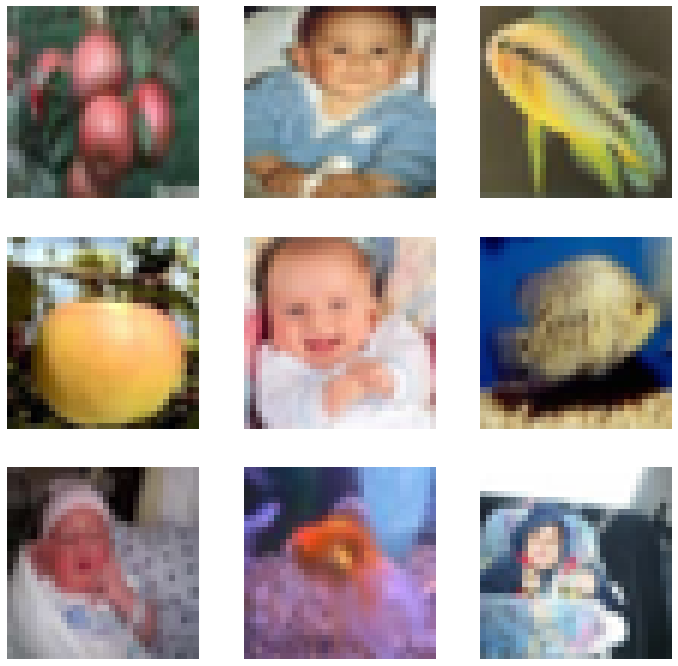

In [ ]:
# save x_test images
xx_test = x_test
yy_test = y_test

fig = plt.figure(figsize=(12, 12))
for i in range(0,9):
    plt.subplot(330 + 1 + i)
    plt.axis('off')
    plt.imshow(x_train[i])
plt.show()

In [ ]:
# augumentacja

rotation_range=30
shift_range=0.30

datagen = ImageDataGenerator( 
      rotation_range=rotation_range,
      horizontal_flip=True,
      width_shift_range=shift_range,
      height_shift_range=shift_range,
      zoom_range=shift_range
      )  


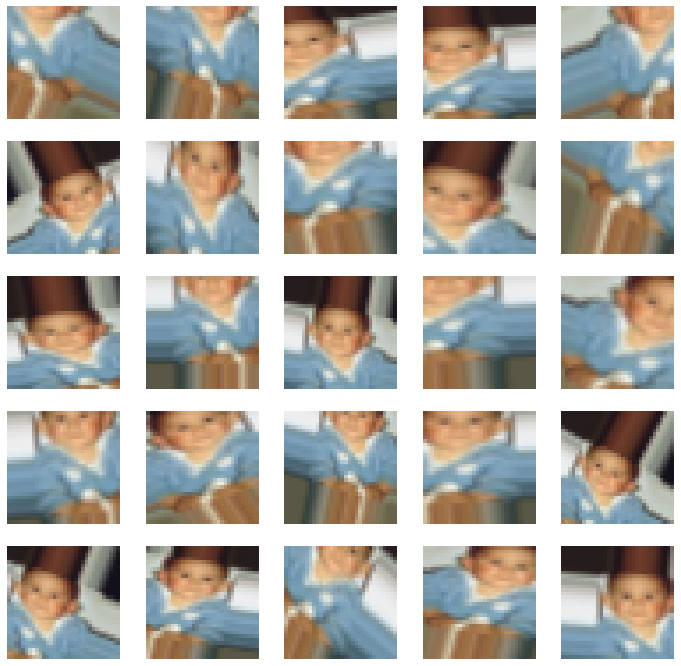

In [ ]:
# przykład augumentacji na jednym obrazku
fig = plt.figure(figsize=(12, 12))

for i in range(0, 25):
    for X_batch, y_batch in datagen.flow(x_train[1:3], y_train[1:3], batch_size=1, shuffle=False):
         plt.subplot(5,5,i+1)
         plt.imshow(X_batch[0].astype(np.uint8))
         plt.axis('off')
         break

plt.show()

In [ ]:
#reshape into images
x_train = x_train.reshape(x_train.shape[0], img_rows, img_cols, channels)
x_test = x_test.reshape(x_test.shape[0], img_rows, img_cols, channels)
print('x_train shape:', x_train.shape)
print(x_train.shape[0], 'train samples')
print(x_test.shape[0], 'test samples')

x_train shape: (1500, 32, 32, 3)
1500 train samples
300 test samples


In [ ]:
#convert integers to float; normalise and center the mean
x_train=x_train.astype("float32")  
x_test=x_test.astype("float32")
mean=np.mean(x_train)
std=np.std(x_train)
x_test=(x_test-mean)/std
x_train=(x_train-mean)/std

# labels to categorical - output is a vector with length = number of classes
y_train = k.utils.to_categorical(y_train, N_CLASSES)
y_test = k.utils.to_categorical(y_test, N_CLASSES)

In [ ]:
#stworzenie sieci konwolucyjnej
def create_model(num_filters2):

  #reg=l2(1e-4)   # L2 or "ridge" regularisation
  reg2=None
  #num_filters2=32
  ac2='relu'
  adm2=Adam(lr=0.001,decay=0, beta_1=0.9, beta_2=0.999, epsilon=1e-08)
  opt2=adm2
  drop_dense2=0.5
  drop_conv2=0

  model2 = Sequential()

  model2.add(Conv2D(num_filters2, (3, 3), activation=ac2, kernel_regularizer=reg2, input_shape=(img_rows, img_cols, channels),padding='same'))
  model2.add(BatchNormalization(axis=-1))
  model2.add(Conv2D(num_filters2, (3, 3), activation=ac2,kernel_regularizer=reg2,padding='same'))
  model2.add(BatchNormalization(axis=-1))
  model2.add(MaxPooling2D(pool_size=(2, 2)))   # reduces to 16x16x3xnum_filters
  model2.add(Dropout(drop_conv2))

  model2.add(Conv2D(2*num_filters2, (3, 3), activation=ac2,kernel_regularizer=reg2,padding='same'))
  model2.add(BatchNormalization(axis=-1))
  model2.add(Conv2D(2*num_filters2, (3, 3), activation=ac2,kernel_regularizer=reg2,padding='same'))
  model2.add(BatchNormalization(axis=-1))
  model2.add(MaxPooling2D(pool_size=(2, 2)))   # reduces to 8x8x3x(2*num_filters)
  model2.add(Dropout(drop_conv2))

  model2.add(Conv2D(4*num_filters2, (3, 3), activation=ac2,kernel_regularizer=reg2,padding='same'))
  model2.add(BatchNormalization(axis=-1))
  model2.add(Conv2D(4*num_filters2, (3, 3), activation=ac2,kernel_regularizer=reg2,padding='same'))
  model2.add(BatchNormalization(axis=-1))
  model2.add(MaxPooling2D(pool_size=(2, 2)))   # reduces to 4x4x3x(4*num_filters)
  model2.add(Dropout(drop_conv2))


  model2.add(Flatten())
  model2.add(Dense(512, activation=ac2,kernel_regularizer=reg2))
  model2.add(BatchNormalization())
  model2.add(Dropout(drop_dense2))
  model2.add(Dense(N_CLASSES, activation='softmax'))

  model2.compile(loss='categorical_crossentropy', metrics=['accuracy'],optimizer=opt2)

  return model2

In [ ]:
#dopasowanie sieci konwolucyjnej
def fit_model(model2, datagen, x_train, y_train, x_val, y_val):

  # train with image augmentation

  es = EarlyStopping(
    monitor="val_accuracy",
    patience=60,
    verbose=1
  )

  history2=model2.fit(datagen.flow(x_train, y_train, batch_size=128),
                     batch_size=128, epochs=50, validation_data=(x_val, y_val), verbose=0)
  return history2, model2

In [ ]:
# OPTUNA

! pip install optuna
import optuna

     |████████████████████████████████| 286kB 16.5MB/s 
     |████████████████████████████████| 81kB 11.3MB/s 
     |████████████████████████████████| 163kB 49.5MB/s 
     |████████████████████████████████| 133kB 52.6MB/s 
     |████████████████████████████████| 112kB 21.1MB/s 
     |████████████████████████████████| 51kB 7.5MB/s 
     |████████████████████████████████| 481kB 52.3MB/s 
  Created wheel for PrettyTable: filename=prettytable-0.7.2-cp36-none-any.whl size=13702 sha256=4836ad7b0f4b0f24efbc01c1ee063e69e80b3b76a1353169fa1412fed8dee593
  Stored in directory: /root/.cache/pip/wheels/80/34/1c/3967380d9676d162cb59513bd9dc862d0584e045a162095606
  Created wheel for Mako: filename=Mako-1.1.4-py2.py3-none-any.whl size=75675 sha256=7459ecde43b01f88c0864374fa94d065f1e7a29760ed43172af0af0d89b7ed79
  Stored in directory: /root/.cache/pip/wheels/ad/10/d3/aeb26e20d19045e2a68e5d3cbb57432e11b5d9c92c99f98d47
  Created wheel for pyperclip: filename=pyperclip-1.8.1-cp36-none-any.whl size=11120 s

In [ ]:
# szacowanie modelu z k-fold i cross-validation
def evaluate_model(dataX, dataY, n_folds=5, datagen=datagen, num_filters=32):

  scores=[]
  histories=[]
  models=[]

  # prepare cross validation
  kfold = KFold(n_folds, shuffle=True, random_state=1)
  # enumerate splits
  for train_ix, test_ix in kfold.split(dataX):
    # define model
      model = create_model(num_filters)
    # select rows for train and test
      trainX, trainY, testX, testY = dataX[train_ix], dataY[train_ix], dataX[test_ix], dataY[test_ix]
    # fit model
      history, model = fit_model(model, datagen, trainX, trainY, testX, testY)
    # evaluate model
      _, acc = model.evaluate(testX, testY, verbose=0)
      print('> %.3f' % (acc * 100.0))
		# stores scores
      scores.append(acc)
      histories.append(history)
      models.append(model)
  return scores, histories, models

In [ ]:
def objective(trial):
  
  rotation_range=trial.suggest_uniform('rotation_range', .00,30)
  shift_range=trial.suggest_uniform('shift_range', .00,0.20)
  num_filters =trial.suggest_uniform('num_filters', .00,50)
  
  datagen = ImageDataGenerator( 
      rotation_range=rotation_range,
      horizontal_flip=True,
      width_shift_range=shift_range,
      height_shift_range=shift_range,
      zoom_range=shift_range
  )
  datagen.fit(x_train)


  #create and evaluate model
  scores, histories, models = evaluate_model(x_train, y_train, n_folds=5, datagen=datagen, num_filters=num_filters)

  return np.mean(scores)

In [ ]:
#Optymalizacja
study = optuna.create_study(direction='maximize', pruner=optuna.pruners.MedianPruner(), sampler=optuna.samplers.TPESampler() )
study.optimize(objective, n_trials=30)

[I 2021-01-15 19:06:43,631] A new study created in memory with name: no-name-c0ae2c00-62d1-4659-9cd2-97ea298568d0


> 86.333
> 91.000
> 90.333
> 89.333


[I 2021-01-15 19:09:38,153] Trial 0 finished with value: 0.8919999957084656 and parameters: {'rotation_range': 19.639215173387463, 'shift_range': 0.19073985251831482, 'num_filters': 14.621677991330873}. Best is trial 0 with value: 0.8919999957084656.


> 89.000
> 87.667
> 92.000
> 90.000
> 90.000


[I 2021-01-15 19:12:22,114] Trial 1 finished with value: 0.9013333320617676 and parameters: {'rotation_range': 4.878615309643153, 'shift_range': 0.018408091978378716, 'num_filters': 43.38526214286833}. Best is trial 1 with value: 0.9013333320617676.


> 91.000
> 92.333
> 92.000
> 90.667
> 90.333


[I 2021-01-15 19:15:04,710] Trial 2 finished with value: 0.9113333344459533 and parameters: {'rotation_range': 14.370707104156903, 'shift_range': 0.04713567259179368, 'num_filters': 30.616779755137124}. Best is trial 2 with value: 0.9113333344459533.


> 90.333
> 92.000
> 90.333
> 93.000
> 90.333


[I 2021-01-15 19:17:45,137] Trial 3 finished with value: 0.9106666564941406 and parameters: {'rotation_range': 25.275046482537874, 'shift_range': 0.0845506753054681, 'num_filters': 17.690570583121374}. Best is trial 2 with value: 0.9113333344459533.


> 89.667
> 90.000
> 92.667
> 91.333
> 90.333


[I 2021-01-15 19:20:29,461] Trial 4 finished with value: 0.9153333306312561 and parameters: {'rotation_range': 14.689219449074859, 'shift_range': 0.0914683670862724, 'num_filters': 43.4054368580677}. Best is trial 4 with value: 0.9153333306312561.


> 93.333
> 90.000
> 91.333
> 87.667
> 89.667


[I 2021-01-15 19:23:12,918] Trial 5 finished with value: 0.8979999899864197 and parameters: {'rotation_range': 3.0528714577482607, 'shift_range': 0.0456405658400578, 'num_filters': 32.50643395227679}. Best is trial 4 with value: 0.9153333306312561.


> 90.333
> 92.000
> 92.000
> 92.000
> 92.667


[I 2021-01-15 19:25:59,099] Trial 6 finished with value: 0.9200000166893005 and parameters: {'rotation_range': 24.0987602429502, 'shift_range': 0.12908736351596004, 'num_filters': 49.33447010214021}. Best is trial 6 with value: 0.9200000166893005.


> 91.333
> 90.333
> 89.667
> 91.333
> 89.667


[I 2021-01-15 19:28:39,464] Trial 7 finished with value: 0.8986666560173034 and parameters: {'rotation_range': 21.380449012597982, 'shift_range': 0.12304907660848995, 'num_filters': 15.045875924157121}. Best is trial 6 with value: 0.9200000166893005.


> 88.333
> 91.000
> 87.667
> 88.333
> 90.333


[I 2021-01-15 19:31:20,659] Trial 8 finished with value: 0.8933333277702331 and parameters: {'rotation_range': 5.026080708366223, 'shift_range': 0.05009628185090423, 'num_filters': 21.333976245136842}. Best is trial 6 with value: 0.9200000166893005.


> 89.333
> 91.333
> 92.667
> 86.667
> 92.667


[I 2021-01-15 19:34:05,693] Trial 9 finished with value: 0.9046666741371154 and parameters: {'rotation_range': 26.5208715933474, 'shift_range': 0.1473078108450525, 'num_filters': 35.29888880941721}. Best is trial 6 with value: 0.9200000166893005.


> 89.000
> 74.333
> 80.333
> 69.000
> 78.333


[I 2021-01-15 19:36:45,477] Trial 10 finished with value: 0.7533333420753479 and parameters: {'rotation_range': 29.34414041622152, 'shift_range': 0.1960304375242471, 'num_filters': 2.2898309957339613}. Best is trial 6 with value: 0.9200000166893005.


> 74.667
> 91.333
> 93.667
> 92.333
> 91.333


[I 2021-01-15 19:39:31,090] Trial 11 finished with value: 0.9180000066757202 and parameters: {'rotation_range': 12.661826117990138, 'shift_range': 0.10167831913240677, 'num_filters': 47.119692082193666}. Best is trial 6 with value: 0.9200000166893005.


> 90.333
> 91.667
> 93.333
> 91.333
> 94.000


[I 2021-01-15 19:42:17,737] Trial 12 finished with value: 0.9200000047683716 and parameters: {'rotation_range': 11.755788541559653, 'shift_range': 0.1533251609383948, 'num_filters': 49.762678771836406}. Best is trial 6 with value: 0.9200000166893005.


> 89.667
> 93.667
> 93.333
> 88.333
> 91.333


[I 2021-01-15 19:45:04,951] Trial 13 finished with value: 0.9180000066757202 and parameters: {'rotation_range': 11.128357526476147, 'shift_range': 0.15926025724429665, 'num_filters': 49.53531898055551}. Best is trial 6 with value: 0.9200000166893005.


> 92.333
> 90.667
> 94.333
> 91.333
> 93.333


[I 2021-01-15 19:47:50,849] Trial 14 finished with value: 0.9226666808128356 and parameters: {'rotation_range': 8.866547167924125, 'shift_range': 0.15618831484014595, 'num_filters': 39.16115321013526}. Best is trial 14 with value: 0.9226666808128356.


> 91.667
> 92.000
> 93.333
> 92.333
> 92.333


[I 2021-01-15 19:50:37,277] Trial 15 finished with value: 0.924666678905487 and parameters: {'rotation_range': 7.99416568272617, 'shift_range': 0.17349161891426362, 'num_filters': 38.81560775515514}. Best is trial 15 with value: 0.924666678905487.


> 92.333
> 91.333
> 91.667
> 93.333
> 90.667


[I 2021-01-15 19:53:22,968] Trial 16 finished with value: 0.9160000205039978 and parameters: {'rotation_range': 7.739364585265079, 'shift_range': 0.17770480380539683, 'num_filters': 37.63684575335917}. Best is trial 15 with value: 0.924666678905487.


> 91.000
> 91.333
> 91.000
> 91.333
> 89.000


[I 2021-01-15 19:56:08,499] Trial 17 finished with value: 0.9073333501815796 and parameters: {'rotation_range': 0.20461887670401424, 'shift_range': 0.17716086546598253, 'num_filters': 27.35882825380866}. Best is trial 15 with value: 0.924666678905487.


> 91.000
> 89.333
> 93.333
> 91.333
> 92.000


[I 2021-01-15 19:58:55,087] Trial 18 finished with value: 0.9146666765213013 and parameters: {'rotation_range': 8.926437351250712, 'shift_range': 0.1357273886091798, 'num_filters': 39.781243150807036}. Best is trial 15 with value: 0.924666678905487.


> 91.333
> 91.000
> 90.667
> 91.000
> 89.667


[I 2021-01-15 20:01:43,697] Trial 19 finished with value: 0.9026666760444642 and parameters: {'rotation_range': 17.964687986283455, 'shift_range': 0.17002068440100068, 'num_filters': 42.01722400986242}. Best is trial 15 with value: 0.924666678905487.


> 89.000
> 92.667
> 89.667
> 92.000
> 91.667


[I 2021-01-15 20:04:27,928] Trial 20 finished with value: 0.9106666684150696 and parameters: {'rotation_range': 8.618627363453594, 'shift_range': 0.1131287343245502, 'num_filters': 25.690757666955257}. Best is trial 15 with value: 0.924666678905487.


> 89.333
> 93.667
> 91.333
> 91.000
> 89.333


[I 2021-01-15 20:07:13,563] Trial 21 finished with value: 0.9073333382606507 and parameters: {'rotation_range': 0.4959908033793745, 'shift_range': 0.13235109391406347, 'num_filters': 48.52506323866634}. Best is trial 15 with value: 0.924666678905487.


> 88.333
> 91.667
> 92.000
> 84.000
> 90.667


[I 2021-01-15 20:09:56,658] Trial 22 finished with value: 0.8960000038146972 and parameters: {'rotation_range': 17.2933921766223, 'shift_range': 0.1454743765680867, 'num_filters': 35.48470620210504}. Best is trial 15 with value: 0.924666678905487.


> 89.667
> 89.333
> 90.333
> 93.000
> 93.333


[I 2021-01-15 20:12:40,901] Trial 23 finished with value: 0.9133333325386047 and parameters: {'rotation_range': 7.167260814367873, 'shift_range': 0.1688927383750705, 'num_filters': 43.69503194482745}. Best is trial 15 with value: 0.924666678905487.


> 90.667
> 91.333
> 92.333
> 92.333
> 92.333


[I 2021-01-15 20:15:22,360] Trial 24 finished with value: 0.9140000104904175 and parameters: {'rotation_range': 23.440973496863666, 'shift_range': 0.11422522058256579, 'num_filters': 30.961222438724725}. Best is trial 15 with value: 0.924666678905487.


> 88.667
> 93.333
> 89.333
> 93.000
> 91.667


[I 2021-01-15 20:18:05,059] Trial 25 finished with value: 0.9146666646003723 and parameters: {'rotation_range': 2.780674970146359, 'shift_range': 0.19576200017086515, 'num_filters': 38.9844019530348}. Best is trial 15 with value: 0.924666678905487.


> 90.000
> 92.000
> 92.333
> 92.000
> 90.333


[I 2021-01-15 20:20:48,776] Trial 26 finished with value: 0.9146666765213013 and parameters: {'rotation_range': 29.85981300368621, 'shift_range': 0.13465809211952648, 'num_filters': 45.92774911341055}. Best is trial 15 with value: 0.924666678905487.


> 90.667
> 79.000
> 84.333
> 81.667
> 81.333


[I 2021-01-15 20:23:23,932] Trial 27 finished with value: 0.8120000004768372 and parameters: {'rotation_range': 5.800800690463325, 'shift_range': 0.07347602423286531, 'num_filters': 3.8075970884292616}. Best is trial 15 with value: 0.924666678905487.


> 79.667
> 93.000
> 90.000
> 93.333
> 94.333


[I 2021-01-15 20:26:07,459] Trial 28 finished with value: 0.9279999971389771 and parameters: {'rotation_range': 10.463309922700704, 'shift_range': 0.1869253686283031, 'num_filters': 39.867065195342285}. Best is trial 28 with value: 0.9279999971389771.


> 93.333
> 88.000
> 86.333
> 88.333
> 89.000


[I 2021-01-15 20:28:44,705] Trial 29 finished with value: 0.8740000009536744 and parameters: {'rotation_range': 10.312341189362025, 'shift_range': 0.1985407199807539, 'num_filters': 8.217780392787038}. Best is trial 28 with value: 0.9279999971389771.


> 85.333


In [ ]:
print("Number of finished trials: {}".format(len(study.trials)))

print("Best trial:")
trial = study.best_trial

print("  Value: {}".format(trial.value))

print("  Params: ")
for key, value in trial.params.items():
        print("    {}: {}".format(key, value))


Number of finished trials: 30
Best trial:
  Value: 0.9279999971389771
  Params: 
    rotation_range: 10.463309922700704
    shift_range: 0.1869253686283031
    num_filters: 39.867065195342285


In [ ]:
# trening z zoptymalizowanymi parametrami
num_filters =trial.params.get('num_filters') 
rotation_range=trial.params.get('rotation_range')
shift_range=trial.params.get('shift_range')
  
datagen = ImageDataGenerator( 
    rotation_range=rotation_range,
    width_shift_range=shift_range,
    height_shift_range=shift_range,
    zoom_range=shift_range
    )

datagen.fit(x_train)

#create and evaluate model
scores, histories, models = evaluate_model(x_train, y_train, n_folds=5, datagen=datagen)

> 89.667
> 86.333
> 90.000
> 90.000
> 89.000


In [ ]:
#Wykresy
 
# plot diagnostic learning curves
def summarize_diagnostics(histories):
  plt.figure(figsize=(10,10))
  for i in range(len(histories)):
		# plot loss
    plt.subplot(2, 1, 1)
    plt.title('Loss')
    plt.plot(histories[i].history['loss'], color='blue', label='train')
    plt.plot(histories[i].history['val_loss'], color='orange', label='test')
    #plt.ylim(0,0.1)
    plt.legend(['loss','val_loss'])
    # plot accuracy
    plt.subplot(2, 1, 2)
    plt.title('Classification Accuracy')
    plt.plot(histories[i].history['accuracy'], color='blue', label='train')
    plt.plot(histories[i].history['val_accuracy'], color='orange', label='test')
    #plt.ylim(0.9,1)
    plt.legend(['accuracy','val_accuracy'])
  plt.show()
 
# summarize model performance
def summarize_performance(scores):
	# print summary
  print('Accuracy: mean=%.3f std=%.3f, n=%d' % (np.mean(scores)*100, np.std(scores)*100, len(scores)))
	# box and whisker plots of results
  plt.figure(figsize=(10,10))
  plt.boxplot(scores)
  plt.show()

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:8: MatplotlibDeprecationWarning:

Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:15: MatplotlibDeprecationWarning:

Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.



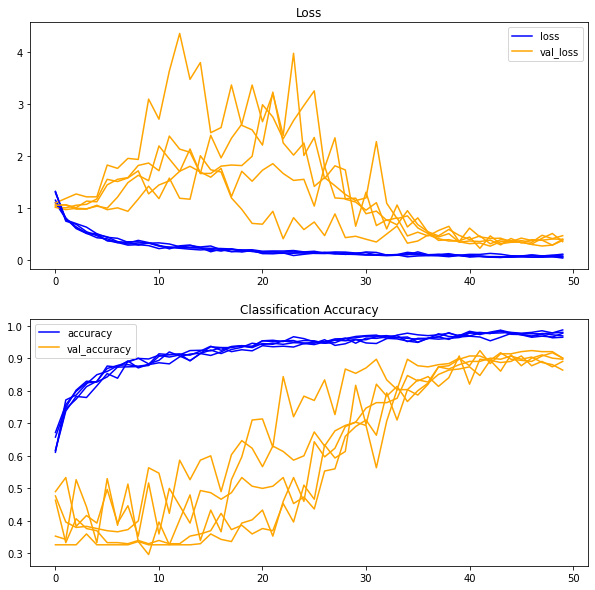

Accuracy: mean=89.000 std=1.382, n=5


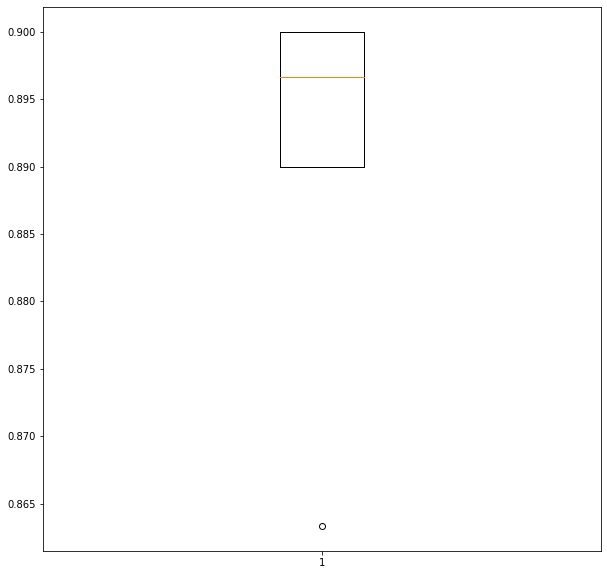

Scores:  [0.8966666460037231, 0.8633333444595337, 0.8999999761581421, 0.8999999761581421, 0.8899999856948853]


In [ ]:
# learning curves
summarize_diagnostics(histories)
# summarize estimated performance
summarize_performance(scores)
 
print("Scores: ",scores)

In [ ]:
# make predictions
yhats = [model.predict(x_test) for model in models]
yhats = np.array(yhats)
# sum across ensembles
summed = np.sum(yhats, axis=0)/len(models)
# argmax across classes
outcomes = np.argmax(summed, axis=1)

# true outcomes
outcomes_true = np.argmax(y_test,axis = 1)


score = (len(outcomes) - np.count_nonzero(outcomes-outcomes_true))/len(outcomes)

print("Ensamble test accuracy: ",score*100.,"%")


Ensamble test accuracy:  94.0 %


In [ ]:
# Confusion matrix result

from sklearn.metrics import classification_report, confusion_matrix

#confusion matrix
cm = confusion_matrix(outcomes_true,outcomes)
print(cm)



[[96  0  4]
 [ 2 98  0]
 [ 6  6 88]]


In [ ]:
def plot_images2(y_pred, y_pred_prob):
# Names of predicted classes (randomly chosen images)

  import random


  class_names = ["apple", "fish", "child", "bear", "beaver", "bed", "bee", "horse", "ship", "truck"]

  #y_pred = model2.predict_classes(x_test)
  #y_pred_prob = model2.predict(x_test)

  grid_w = 10
  grid_h = 10

  fig = plt.figure(figsize=(20, 40))
  for i in range(0,grid_w*grid_h):
    i_pos = 2*(int(i/grid_w))*grid_w+ i%grid_w + 1
    #print(i_pos)
    plt.subplot(2*grid_h, grid_w, i_pos)
    i_img = random.randint(0,len(xx_test))
    plt.imshow(xx_test[i_img])
    #plt.bar([0,1,2,3,4,5,6,7,8,9],y_test[i_img])
    plt.axis('off')
    if yy_test[i_img] == y_pred[i_img]:
      plt.text(0, -2, class_names[int(yy_test[i_img])], color='green', fontsize=12)
    else:
      plt.text(0, -2, class_names[int(yy_test[i_img])]+" "+class_names[y_pred[i_img]], color='red', fontsize=12)  
    plt.subplot(2*grid_h, grid_w, i_pos + grid_w)
    xbar = np.linspace(1, N_CLASSES, num=N_CLASSES)
    plt.bar(xbar,y_pred_prob[i_img])
    plt.axis('off')

  plt.show()


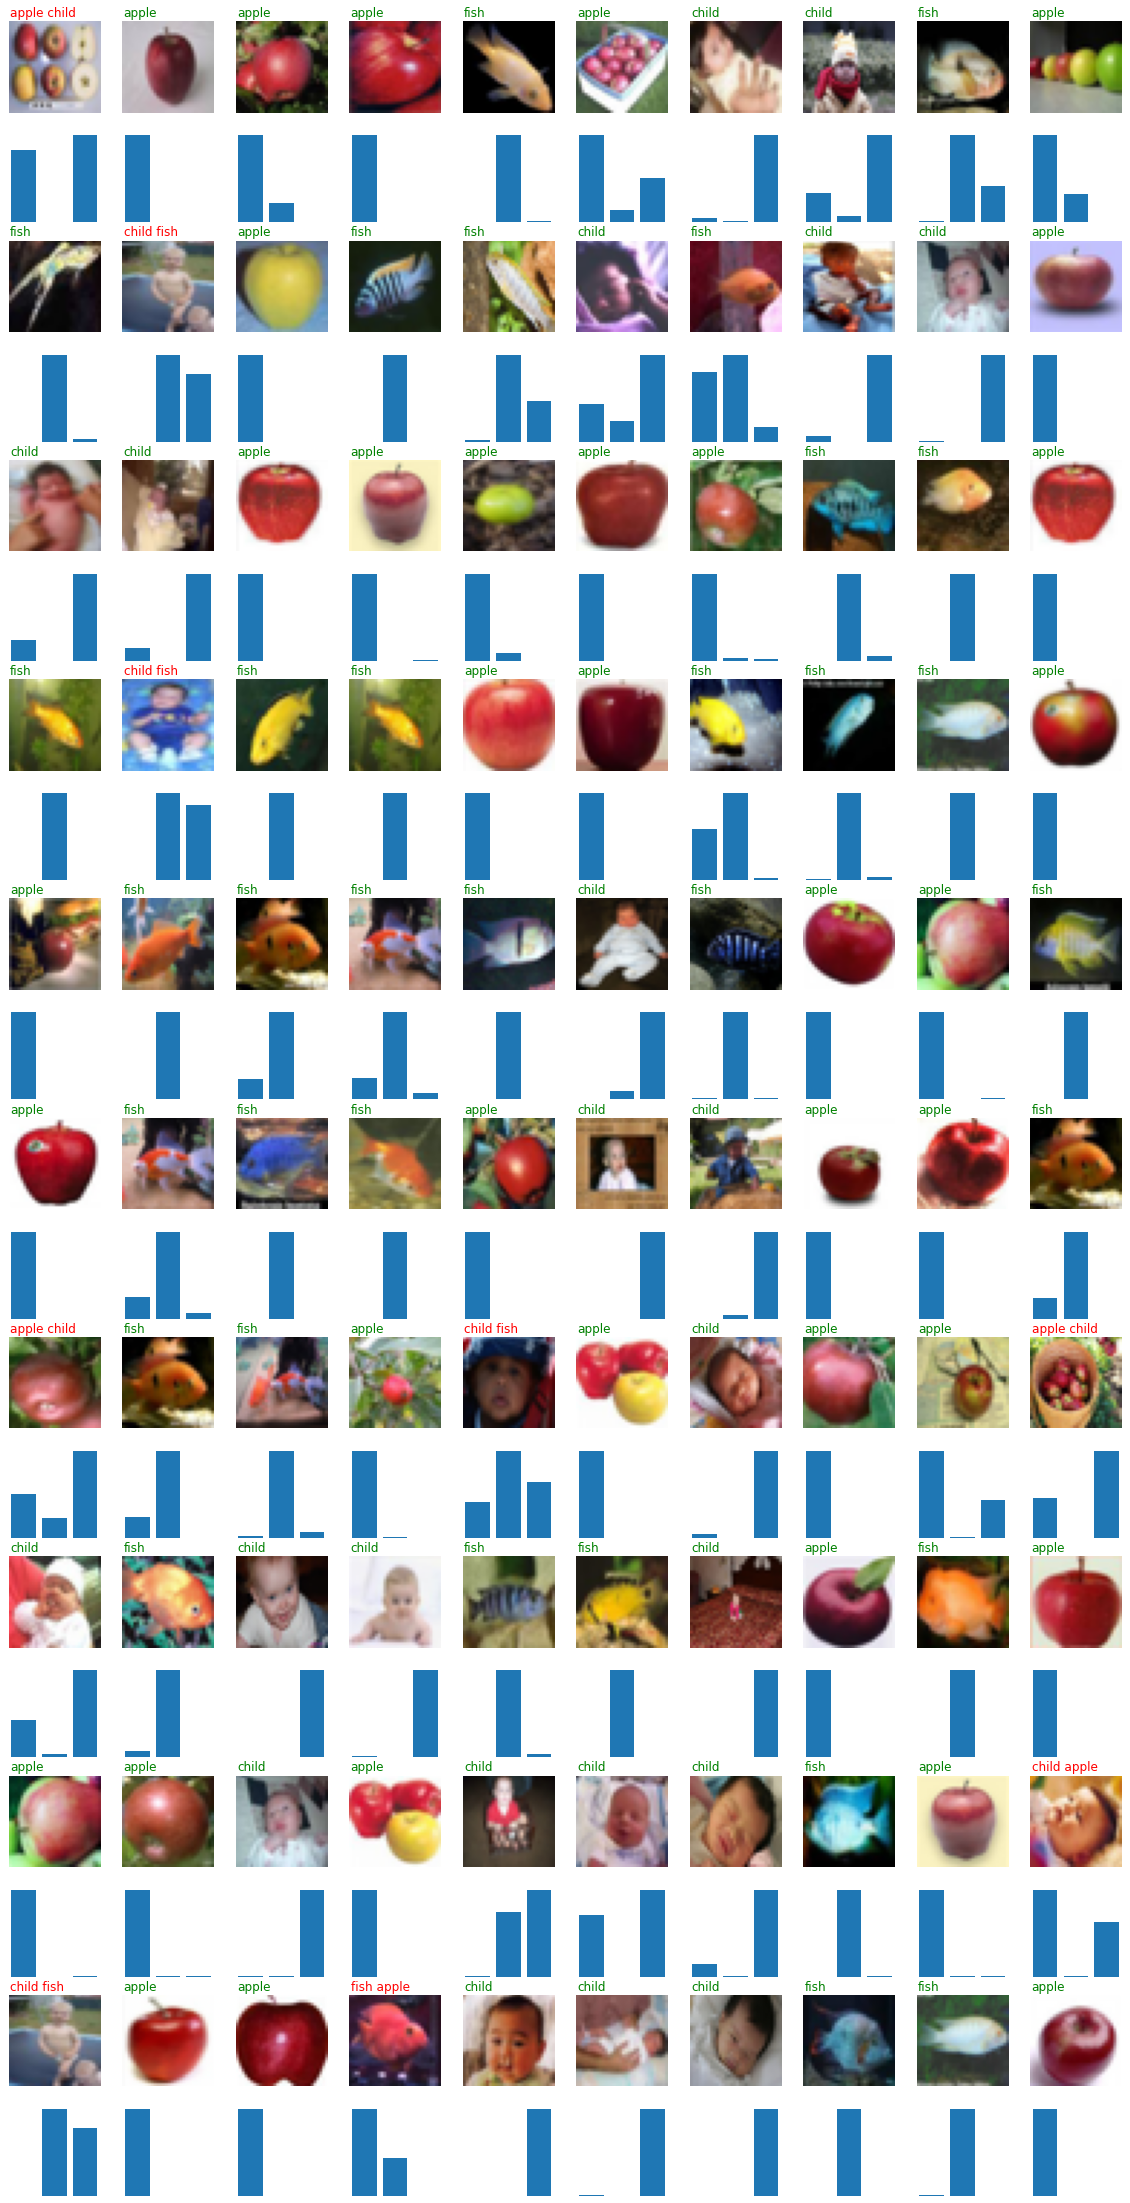

In [ ]:
plot_images2(outcomes,summed)

# Wizualizacje

In [ ]:
from optuna.visualization import plot_optimization_history

plot_optimization_history(study)

In [ ]:
from optuna.visualization import plot_parallel_coordinate

plot_parallel_coordinate(study)

In [ ]:
from optuna.visualization import plot_contour

plot_contour(study)

In [ ]:
from optuna.visualization import plot_slice

plot_slice(study)

In [ ]:
from optuna.visualization import plot_param_importances

plot_param_importances(study)